<a href="https://colab.research.google.com/github/Estrada-John/SpamClassification/blob/master/Spam_Classification_Using_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3><center>ECE 49500/59500 Machine Learning<center>
<center>Spring 2020<center>
<h2><center>Spam Email Classification using Naive Bayes Classifier<center>

## Context

You will use the SMS Spam Collection dataset which is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

## Content

The files contain one message per line. Each line is composed by two columns: **v1 contains the label (ham or spam) and v2 contains the raw text.**  This corpus has been collected from free or free for research sources at the Internet. More details can be found in here: https://www.kaggle.com/uciml/sms-spam-collection-dataset

## Objective

Apply Naive Bayes Classifier to this dataset to accurately predict which texts are spam.

## 1. Contents of this notebook

*  Text Analysis
        - Explore the Data
        - Developing Insights
*  Test Transformation
        - Data Cleaning (Removing unimportant data/ Stopwords/ Stemming)
        - Converting data into a model usable format (Bag of words Model)
*  Naive Bayes Model for Spam Classification


#### TEXT ANALYSIS

In [16]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Text Preprocessing
import nltk
nltk.download("all")   # you will need to download it if you have not done so
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

* #####  Load dataset.  We will use Pandas library to load the dataset. More information regarding Pandas can be found at https://pandas.pydata.org/

In [17]:
## Upload file from google colab
from google.colab import drive 
drive.mount('/content/gdrive')
messages=pd.read_csv('gdrive/My Drive/Colab Notebooks/Machine Learning/spam.csv', encoding = 'latin-1' )

## Upload file from any python IDE
#messages = pd.read_csv("spam.csv", encoding = 'latin-1')

# Drop the extra columns and rename columns
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["category", "text"]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [18]:
display(messages.head(n = 20))

,category,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


* ##### Check overall information of the dataset

In [19]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
category    5572 non-null object
text        5572 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


* ##### Let us see what precentage of our data is spam or ham (legitimate)

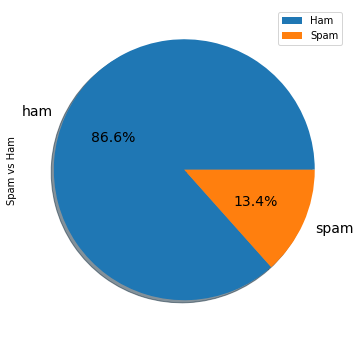

In [20]:
messages["category"].value_counts().plot(kind = 'pie', figsize = (6, 6), fontsize=14, autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

From above Pie chart, it can be seen that about 86% of our dataset consists of non-spam messages. 

*  As we split our data set into train and test, **stratified sampling** is recommended in this case, otherwise we have a chance of our training model being skewed towards normal messages. If the sample we choose to train our model consists majorly of normal messages, it may end up predicting everything as ham and we might not be able to figure this out since most of the messages we get are actually ham and will have a pretty good accuracy.

* #####  now let us check individual Spam/ham words

In [21]:
spam_messages = messages[messages["category"] == "spam"]["text"]
ham_messages = messages[messages["category"] == "ham"]["text"]

spam_words = []
ham_words = []

# Since this is just classifying the message as spam or ham, we can use isalpha(). 
# This will also remove the not word in something like can't etc. 
# In a sentiment analysis setting, it's better to use sentence.translate(string.maketrans("", "", ), chars_to_remove)

def extractSpamWords(spamMessages):
    global spam_words
    words = [word.lower() for word in word_tokenize(spamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    spam_words = spam_words + words
    
def extractHamWords(hamMessages):
    global ham_words
    words = [word.lower() for word in word_tokenize(hamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    ham_words = ham_words + words

spam_messages.apply(extractSpamWords)
ham_messages.apply(extractHamWords)

0       None
1       None
3       None
4       None
6       None
        ... 
5565    None
5568    None
5569    None
5570    None
5571    None
Name: text, Length: 4825, dtype: object

In [22]:
print("Total Messages:" , len(ham_messages) + len(spam_messages))

Total Messages: 5572


In [23]:
# Top 10 spam words
spam_words = np.array(spam_words)
print("Top 10 Spam words are :\n")
pd.Series(spam_words).value_counts().head(n = 10)

Top 10 Spam words are :



call      346
free      217
txt       156
u         144
ur        144
mobile    123
text      121
stop      114
claim     113
reply     104
dtype: int64

In [24]:
# Top 10 Ham words
ham_words = np.array(ham_words)
print("Top 10 Ham words are :\n")
pd.Series(ham_words).value_counts().head(n = 10)

Top 10 Ham words are :



u       974
gt      318
lt      316
get     301
go      246
ok      246
got     242
ur      237
know    234
like    231
dtype: int64

* #### Does the length of the message indicates us anything?

In [25]:
messages["messageLength"] = messages["text"].apply(len)
messages["messageLength"].describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: messageLength, dtype: float64

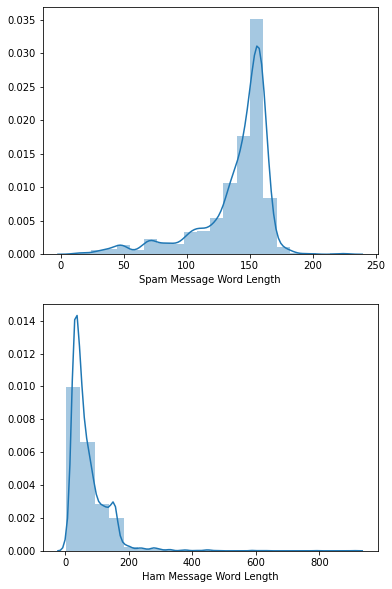

In [26]:
f, ax = plt.subplots(2, 1, figsize = (6, 10))

sns.distplot(messages[messages["category"] == "spam"]["messageLength"], bins = 20, ax = ax[0])
ax[0].set_xlabel("Spam Message Word Length")

sns.distplot(messages[messages["category"] == "ham"]["messageLength"], bins = 20, ax = ax[1])
ax[1].set_xlabel("Ham Message Word Length")

plt.show()

**It can be observed that spam messages are usually longer which could be a a feature to predict whether the message is spam/ ham. Right?**

#### TEXT TRANSFORMATION

#### Lets clean our data by removing punctuations/ stopwords and stemming words
* __Stemming__ reduces related words to a common stem. e.g., fish and fishes become 'fish'
* __Stop words__ are commonly used words that are unlikely to have any benefit in natural language processing. These includes words such as ‘a’, ‘the’, ‘is’.

More references: https://pythonhealthcare.org/2018/12/14/101-pre-processing-data-tokenization-stemming-and-removal-of-stop-words/

In [27]:
from nltk.stem import SnowballStemmer
def stemmer(text):
    text = text.split()
    words = ""
    for i in text:
            stemmer = SnowballStemmer("english")
            words += (stemmer.stem(i))+" "
    return words

def puncStopW(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)

messages["text"] = messages["text"].apply(stemmer)
messages["text"] = messages["text"].apply(puncStopW)
messages.head(n = 10)     # You may compare the different between orginaltext and filtered one to see the difference

,category,text,messageLength
0,ham,go jurong point crazy avail onli bugi n great ...,111
1,ham,ok lar joke wif u oni,29
2,spam,free entri 2 wkli comp win fa cup final tkts 2...,155
3,ham,u dun say earli hor u c alreadi say,49
4,ham,nah dont think goe usf live around though,61
5,spam,freemsg hey darl 3 week word back id like fun ...,148
6,ham,even brother like speak treat like aid patent,77
7,ham,per request mell mell oru minnaminungint nurun...,160
8,spam,winner valu network custom select receivea å£9...,158
9,spam,mobil 11 month u r entitl updat latest colour ...,154


##### Convert the clean text into a feature representation

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
features_np = vec.fit_transform(messages["text"]).toarray()  # converting to array
print(features_np.shape)

(5572, 8791)


## 2. MODEL APPLICATION

In this section, you will implement the Naive Bayes Classifier to the input data and predict a given email is spam or ham. 

### 2.1 Firstly, convert category of SPAM and HAM messages into 1 and 0, respectively. And then split the data into training set and test set 

In [29]:
print(messages["category"])
def encodeCategory(cat):
    if cat == "spam":
        return 1
    else:
        return 0
       
messages["category"] = messages["category"].apply(encodeCategory)

# convert dataframe to numpy array
messages_np = messages["category"].to_numpy()
print(messages_np)


0        ham
1        ham
2       spam
3        ham
4        ham
        ... 
5567    spam
5568     ham
5569     ham
5570     ham
5571     ham
Name: category, Length: 5572, dtype: object
[0 0 1 ... 0 0 0]


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_np, messages_np, stratify = messages_np, test_size = 0.3, random_state=1)

In [31]:
print("The size of ham messages:", len(ham_messages))
print("The size of spam messages:", len(spam_messages))
print("The size of total samples:", len(messages["category"]))
print("The size of trainng samples:", X_train.shape)
print("The size of testing samples:", X_test.shape)
print("The size of spam messages in training samples:", len(y_train[y_train==1]))
print("The size of ham messages in training samples:", len(y_train[y_train==0]))

The size of ham messages: 4825
The size of spam messages: 747
The size of total samples: 5572
The size of trainng samples: (3900, 8791)
The size of testing samples: (1672, 8791)
The size of spam messages in training samples: 523
The size of ham messages in training samples: 3377


### 2.2 Naive Bayes Classifier Implementation

#### 1) Sort data into two classes: spam and non-spam

In [32]:
Xy0 = X_train[y_train == 0]
Xy1 = X_train[y_train == 1]
print("The size of ham samples in training data:", Xy0.shape)
print("The size of spam samples in training data:", Xy1.shape)

The size of ham samples in training data: (3377, 8791)
The size of spam samples in training data: (523, 8791)


#### 2) Calculate conditional Probability, prior probability (Feel free to build functions and use multiple cells to complete this step)

In [0]:
# 1)
priorHam = Xy0.shape[0] / X_train.shape[0]
priorSpam = Xy1.shape[0] / X_train.shape[0]

#
totalRowHam = np.sum(Xy0, axis=1)
wordsHam = np.sum(totalRowHam, axis=0) 

totalRowSpam = np.sum(Xy1, axis=1)
wordsSpam = np.sum(totalRowSpam, axis=0) 

In [0]:
# 2.0) probability of each word given a specific class
def conditional(Spam, Ham):
    ProbSpam = np.sum(Xy1, axis=0)
    ProbHam = np.sum(Xy0, axis=0)
    probabilityS = lambda x: (x + 1) / (wordsSpam + X_train.shape[1])
    probabilityH = lambda x: (x + 1) / (wordsHam + X_train.shape[1])
    return probabilityS(ProbSpam), probabilityH(ProbHam)

In [35]:
# 2.1) get ptobability
ConditionalSpam, ConditionalHam = conditional(Xy1, Xy0)
print(ConditionalHam)
print(ConditionalSpam)

[2.85616360e-05 2.85616360e-05 2.85616360e-05 ... 2.85616360e-05
 1.14246544e-04 5.71232720e-05]
[5.80990007e-05 1.16198001e-04 5.80990007e-05 ... 1.16198001e-04
 5.80990007e-05 5.80990007e-05]


#### 3) Classify test examples

In [0]:
posteProb_spam = np.array([])
posteProb_ham = np.array([])
X_testTemp = np.array([])
prob_s = 1
prob_h = 1
for i in range(0, X_test.shape[0]):
    for j in range(0, X_test.shape[1]):
        if(X_test[i][j] == 1): 
            prob_s *= ConditionalSpam[j]
            prob_h *= ConditionalHam[j]
    posteProb_spam = np.append(posteProb_spam, prob_s * priorSpam)
    posteProb_ham = np.append(posteProb_ham, prob_h * priorHam )

In [37]:
converter = lambda x,y : x*y if (x == 1).all else (x*1)
a = converter(X_train, ConditionalSpam)
b = converter(X_train, ConditionalHam)
w1 = np.array([])
w2 = np.array([])
for i in range(0, X_test.shape[0]):
    z = np.trim_zeros(a[i])
    y = np.trim_zeros(b[i])
    w1 = np.append(w1, np.prod(z))
    w2 = np.append(w2, np.prod(y))
    #print(w1, w2)

preAcc = lambda x,y : 1 if (x > y).any else (0)
#zx = preAcc(w1, w2)
print(w1)
#print(np.trim_zeros(a.))
#np.trim_zeros(a[0])
#np.multiply(a[0])
#np.count_nonzero(a[0] > 0)


[0. 0. 0. ... 0. 0. 0.]


In [38]:
totalRowHam = np.sum(X_test, axis=1)
totalRowHam[0:50]

array([ 4,  4,  3, 18, 14,  5,  4,  5, 11,  5,  6,  4,  7, 10, 12, 10, 13,
        2,  1,  3,  9,  7,  5,  3,  4,  4, 13,  5,  5,  4, 13, 17,  1,  6,
        5,  5,  4, 18,  3,  7, 18,  4,  5, 16, 23,  2,  7, 18,  3, 20])

#### 4) Compute prediction accuracy

In [40]:
temp = np.array([])
for i in range(0, X_test.shape[0]):
    if (prob_s > prob_h):
        temp = np.append(temp, 1)
    else:
        temp = np.append(temp, 0)

accuracy = 0
for i in range(0, X_test.shape[0]):
    if (temp[i] == y_test[i]):
        accuracy += 1 
        
print(accuracy / y_test.shape[0])

0.8660287081339713


<h2><center>Enjoy !<center>

### <center>Acknowledgement<center>
**The section 1** in this exercise is modified from online source: https://www.kaggle.com/ishansoni/sms-spam-collection-dataset

The original dataset can be found here (https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection). More references can be found at http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/ and A comprehensive study of this corpus in the following paper. 

Almeida, T.A., GÃ³mez Hidalgo, J.M., Yamakami, A. Contributions to the Study of SMS Spam Filtering: New Collection and Results. Proceedings of the 2011 ACM Symposium on Document Engineering (DOCENG'11), Mountain View, CA, USA, 2011.